In [1]:
import os
import librosa
import torch
import re
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torchvision import datasets, transforms
import random
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# 1 Dataset

Import the dataset through kaggle

In [2]:
import kagglehub

path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

print("Path to dataset files:", path)

100%|██████████| 1.21G/1.21G [00:56<00:00, 23.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1


On google colab you can run this to go in the right path to have access to the dataset

In [3]:
cd ..

/


In [4]:
cd root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data/genres_original/jazz/

/root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data/genres_original/jazz


Remove this file, it can't be open

In [5]:
!rm jazz.00054.wav

Get general information about the dataset

In [6]:
print("music genres in the dataset:", list(os.listdir(f'{path}/Data/genres_original/')))
print("number of music genres:", len(list(os.listdir(f'{path}/Data/genres_original/'))))

music genres in the dataset: ['blues', 'reggae', 'disco', 'rock', 'hiphop', 'pop', 'country', 'classical', 'jazz', 'metal']
number of music genres: 10


In [7]:
# Define the directory path
directory = f'{path}/Data/genres_original/'
# Initialize a variable to store the minimum length
min_length = float('inf')
number_files = 0

# Iterate over all files in the directory
for genre in os.listdir(directory):
    genre_path = os.path.join(directory, genre)

    # Ensure it's a directory
    if os.path.isdir(genre_path):
        for filename in os.listdir(genre_path):
            if filename.endswith('.wav'):
                file_path = os.path.join(genre_path, filename)
                number_files += 1
                # Load the audio file using librosa
                y, sr = librosa.load(file_path)

                # Update the minimum length if needed
                min_length = min(min_length, len(y))

print(f"The minimum length of the music time series across all files is: {min_length}, it's corresponds to a minimum of {min_length/22050} seconds")
print("Number of files:", number_files)

The minimum length of the music time series across all files is: 660000, it's corresponds to a minimum of 29.931972789115648 seconds
Number of files: 999


Here we are storing the file names of all the

We do data preprocessing as explained is this paper: https://ismir2010.ismir.net/proceedings/ismir2010-58.pdf. We seperate each audio files (~30 seconds) into small files of only 46.44ms (legnth of 1024) and compute their Discrete Fourier Transform (DFT) as it's symmetric we end up with inputs of size 513.

In the next cell we compute the max and min over all DFTs of the samples of the dataset to be able to then normalize it

In [8]:
# Define the directory path

directory = f'{path}/Data/genres_original/'
dataset_filenames = []
length_time_series = 1024 #corresponds to 46.44ms
maximum = 0
minimum = 100

# Iterate over all files in the directory
for genre in os.listdir(directory):
    genre_path = os.path.join(directory, genre)

    # Ensure it's a directory
    if os.path.isdir(genre_path):
        for filename in os.listdir(genre_path):
            if filename.endswith('.wav'):
                file_path = os.path.join(genre_path, filename)
                for i in range(min_length//1024):
                    dataset_filenames.append((file_path, i))
                    #compute the max and the min (time consuming)
                    # y, _ = librosa.load(file_path, offset = i*1024/22050, duration=length_time_series/22050)
                    #dft = torch.abs(torch.fft.fft(torch.from_numpy(y)))
                    #maximum = max(maximum, torch.max(dft[:513])) #to get the max of the DFTs to normalize the data later
                    #minimum = min(minimum, torch.min(dft[:513])) #to get the min of the DFTs to normalize the data later

print(len(dataset_filenames))

643356


For the minimum, we get 0 and 519.503 for the maximum

Helper function to get the labels of each audio files

In [9]:
def extract_string(input_str):
    # Regular expression to capture the string between the first two slashes and get the class
    match = re.search(r'/([^/]+)/', input_str)
    if match:
        return match.group(1)
    else:
        return None

Create the custom Pytorch dataset, normalize it and split it into train, validation and test dataset

In [10]:
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx][0]
        offset = self.data[idx][1]
        label = extract_string(sample[119:])
        if label == 'blues':
            label = 0
        elif label == 'classical':
            label = 1
        elif label == 'country':
            label = 2
        elif label == 'disco':
            label = 3
        elif label == 'hiphop':
            label = 4
        elif label == 'jazz':
            label = 5
        elif label == 'metal':
            label = 6
        elif label == 'pop':
            label = 7
        elif label == 'reggae':
            label = 8
        elif label == 'rock':
            label = 9
        else:
            print("Error on defining the label")
        if self.transform:
            sample = self.transform(sample, offset*1024/22050)
        return sample, label

# Define a transformation
length_time_series = 1024
def map_data(sample, offset):
    y, _ = librosa.load(sample, offset = offset, duration=length_time_series/22050) #offset: time start of the frame
    dft = torch.abs(torch.fft.fft(torch.from_numpy(y)))
    return (dft[:513] - 0)/(519.503 - 0) # (x_i - min((x_i)))/(max((x_i)) - min((x_i)))



# Set the batch size
BATCH_SIZE = 64
random.seed(42)
random.shuffle(dataset_filenames)
dataset = CustomDataset(dataset_filenames, transform=map_data)

train_size = int(0.6 * len(dataset))
val_size = int(0.3 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

# Define DataLoaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 2 Model

In [11]:
class RBM(nn.Module):
    def __init__(self, n_visible, n_hidden, learning_rate=0.01, batch_size=10):
        super(RBM, self).__init__()
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.learning_rate = learning_rate
        self.batch_size = batch_size

        # Initialize weights and biases
        self.W = nn.Parameter(torch.randn(n_visible, n_hidden) * 0.01)
        self.bx = nn.Parameter(torch.zeros(n_visible))  # visible bias
        self.bh = nn.Parameter(torch.zeros(n_hidden))   # hidden bias

    def sample_prob(self, probs):
        """ Sample binary values based on probabilities """
        return torch.relu(torch.sign(probs - torch.rand(probs.shape, device = probs.device)))

    def forward(self, X):
        """ Propagate input forward to the hidden layer (Gibbs sampling) """
        h_prob = torch.sigmoid(torch.matmul(X, self.W) + self.bh)
        h_sample = self.sample_prob(h_prob)
        return h_sample, h_prob

    def backward(self, H):
        """ Propagate hidden units back to the visible layer """
        x_prob = torch.sigmoid(torch.matmul(H, self.W.t()) + self.bx)
        return x_prob

    def contrastive_divergence(self, X):
        """ Contrastive Divergence algorithm (CD-1) """
        h_sample, h_prob = self.forward(X)

        x_sample = self.sample_prob(self.backward(h_sample))
        h_sample_2, _ = self.forward(x_sample)

        # Compute weight updates
        positive_grad = torch.matmul(X.t(), h_prob)
        negative_grad = torch.matmul(x_sample.t(), h_sample_2)

        dW = (positive_grad - negative_grad) / X.size(0)
        dbx = torch.mean(X - x_sample, dim=0)
        dbh = torch.mean(h_prob - h_sample_2, dim=0)

        # Update weights and biases
        self.W.data.add_(self.learning_rate * dW)
        self.bx.data.add_(self.learning_rate * dbx)
        self.bh.data.add_(self.learning_rate * dbh)

    def train_rbm(self, X, epochs=10, device='cpu'):
        """ Train the RBM on input data X """
        for epoch in range(epochs):
            print(f"Epoch {epoch + 1}/{epochs}")
            with tqdm(total=X.size(0), desc="Training", unit=" samples") as pbar:
                for i in range(0, X.size(0), self.batch_size):
                    batch = X[i:i + self.batch_size].to(device)  # Move batch to device
                    self.contrastive_divergence(batch)
                    pbar.update(self.batch_size)

class DBN(nn.Module):
    def __init__(self, layer_sizes, learning_rate=0.01, batch_size=10):
        super(DBN, self).__init__()
        self.rbm_layers = []
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.batch_size = batch_size

        # Create a stack of RBMs
        for i in range(len(layer_sizes) - 1):
            rbm = RBM(n_visible=layer_sizes[i], n_hidden=layer_sizes[i+1], learning_rate=learning_rate, batch_size=batch_size)
            self.rbm_layers.append(rbm)

    def pretrain(self, train_loader, epochs=10, device='cpu'):
        """ Pretrain the DBN using unsupervised learning (RBMs) """
        input_data = None
        for batch_X, _ in train_loader:
            # Flatten the input images
            batch_X = batch_X.view(batch_X.size(0), -1).to(device)

            # Concatenate batches if input_data is not None
            if input_data is None:
                input_data = batch_X
            else:
                input_data = torch.cat([input_data, batch_X], dim=0)

        # Iterate through RBM layers
        for idx, rbm in enumerate(self.rbm_layers):
            print(f"Pretraining RBM layer {idx + 1}/{len(self.rbm_layers)}")
            rbm.to(device)
            rbm.train_rbm(input_data, epochs=epochs, device=device)

            # Get the transformed input for the next layer
            _, input_data = rbm.forward(input_data)

    def pretrain_forward(self, X):
        """ Forward pass through the pretrained layers """
        for rbm in self.rbm_layers:
            X, _ = rbm.forward(X)
        return X


    def fine_tune(self, train_loader, test_loader, epochs=10, device='cpu'):
        """ Fine-tune the network using supervised learning """
        # Construct a deep feedforward network
        model = nn.Sequential()

        # Add pretrained RBM layers as fully connected layers
        for rbm in self.rbm_layers:
            layer = nn.Linear(rbm.n_visible, rbm.n_hidden)
            layer.weight.data = rbm.W.data.t()
            layer.bias.data = rbm.bh.data
            model.add_module(f"rbm_{rbm.n_hidden}", layer)
            model.add_module(f"sigmoid_{rbm.n_hidden}", nn.Sigmoid())

        # Set the output layer to have 10 units for GTZAN classification
        model.add_module('output', nn.Linear(self.rbm_layers[-1].n_hidden, 10))  # 10 classes for GTZAN

        model = model.to(device)

        # Define optimizer and loss function
        optimizer = optim.Adam(model.parameters(), lr=self.learning_rate)
        criterion = nn.CrossEntropyLoss()

        train_losses = []  # Store training losses
        test_losses = []   # Store test losses
        train_accuracies = []  # Store training accuracies
        test_accuracies = []   # Store test accuracies

        # Training loop
        for epoch in range(epochs):
            model.train()
            train_loss = 0
            correct = 0
            total_samples = 0

            # Use tqdm with train_loader for full dataset iteration
            progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}")
            for batch_X, batch_y in progress_bar:
                batch_X = batch_X.view(batch_X.size(0), -1).to(device)
                batch_y = batch_y.to(device)

                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)  # Get class predictions
                total_samples += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()

                # Update progress bar
                progress_bar.set_postfix({
                    'Loss': f'{train_loss/len(progress_bar):.4f}',
                    'Accuracy on the training set': f'{correct/total_samples:.4f}'
                })

            model.eval()
            test_loss = 0
            with torch.no_grad():
                for batch_X, batch_y in test_loader:
                    batch_X = batch_X.view(batch_X.size(0), -1).to(device)
                    batch_y = batch_y.to(device)
                    outputs = model(batch_X)
                    loss = criterion(outputs, batch_y)
                    test_loss += loss.item()
            test_losses.append(test_loss/len(test_loader))

            # Epoch summary
            epoch_accuracy = correct / total_samples
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss/len(progress_bar):.4f}, Accuracy on the training set: {epoch_accuracy:.4f}")
            train_losses.append(train_loss/len(progress_bar))
            train_accuracies.append(epoch_accuracy)


            # Evaluate the model on test data
            model.eval()
            test_correct = 0
            test_total = 0
            with torch.no_grad():
                for test_X, test_y in test_loader:
                    test_X = test_X.view(test_X.size(0), -1).to(device)
                    test_y = test_y.to(device)
                    outputs = model(test_X)
                    _, predicted = torch.max(outputs, 1)
                    test_total += test_y.size(0)
                    test_correct += (predicted == test_y).sum().item()

            test_accuracy = test_correct / test_total
            print(f"Test Accuracy: {test_accuracy:.4f}")
            test_accuracies.append(test_accuracy)


        # Plot training and test loss
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
        plt.plot(range(1, epochs + 1), test_losses, label='Training Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training Loss Over Epochs')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Plot training and test accuracy
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
        plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training and Test Accuracy Over Epochs')
        plt.legend()
        plt.grid(True)
        plt.show()
        return test_accuracy



# 3 Training

### MNIST dataset

Test on the MNIST dataset to see if the model works

Pretraining RBM layer 1/2
Epoch 1/10


Training: 60032 samples [00:00, 88051.45 samples/s]                     


Epoch 2/10


Training: 60032 samples [00:00, 89461.64 samples/s]                     


Epoch 3/10


Training: 60032 samples [00:00, 90003.12 samples/s]                     


Epoch 4/10


Training: 60032 samples [00:00, 87652.97 samples/s]                     


Epoch 5/10


Training: 60032 samples [00:00, 87972.05 samples/s]                     


Epoch 6/10


Training: 60032 samples [00:00, 90831.93 samples/s]                     


Epoch 7/10


Training: 60032 samples [00:00, 86348.31 samples/s]                     


Epoch 8/10


Training: 60032 samples [00:00, 86526.11 samples/s]                     


Epoch 9/10


Training: 60032 samples [00:00, 89721.50 samples/s]                     


Epoch 10/10


Training: 60032 samples [00:00, 88038.89 samples/s]                     


Pretraining RBM layer 2/2
Epoch 1/10


Training: 60032 samples [00:00, 86981.43 samples/s]                     


Epoch 2/10


Training: 60032 samples [00:00, 86317.85 samples/s]                     


Epoch 3/10


Training: 60032 samples [00:00, 87752.25 samples/s]                     


Epoch 4/10


Training: 60032 samples [00:00, 86969.65 samples/s]                     


Epoch 5/10


Training: 60032 samples [00:00, 84622.30 samples/s]                     


Epoch 6/10


Training: 60032 samples [00:00, 86395.57 samples/s]                     


Epoch 7/10


Training: 60032 samples [00:00, 88815.09 samples/s]                     


Epoch 8/10


Training: 60032 samples [00:00, 88895.86 samples/s]                     


Epoch 9/10


Training: 60032 samples [00:00, 81473.55 samples/s]                     


Epoch 10/10


Training: 60032 samples [00:00, 83167.70 samples/s]                     
Epoch 1/10: 100%|██████████| 938/938 [00:10<00:00, 90.92it/s, Loss=0.1967, Accuracy on the training set=0.9422]


Epoch [1/10], Loss: 0.1967, Accuracy on the training set: 0.9422
Test Accuracy: 0.9662


Epoch 2/10: 100%|██████████| 938/938 [00:09<00:00, 96.70it/s, Loss=0.1040, Accuracy on the training set=0.9677]


Epoch [2/10], Loss: 0.1040, Accuracy on the training set: 0.9677
Test Accuracy: 0.9655


Epoch 3/10: 100%|██████████| 938/938 [00:09<00:00, 96.49it/s, Loss=0.0846, Accuracy on the training set=0.9733]


Epoch [3/10], Loss: 0.0846, Accuracy on the training set: 0.9733
Test Accuracy: 0.9736


Epoch 4/10: 100%|██████████| 938/938 [00:09<00:00, 95.81it/s, Loss=0.0730, Accuracy on the training set=0.9769]


Epoch [4/10], Loss: 0.0730, Accuracy on the training set: 0.9769
Test Accuracy: 0.9688


Epoch 5/10: 100%|██████████| 938/938 [00:09<00:00, 96.39it/s, Loss=0.0660, Accuracy on the training set=0.9799]


Epoch [5/10], Loss: 0.0660, Accuracy on the training set: 0.9799
Test Accuracy: 0.9732


Epoch 6/10: 100%|██████████| 938/938 [00:09<00:00, 95.32it/s, Loss=0.0655, Accuracy on the training set=0.9788]


Epoch [6/10], Loss: 0.0655, Accuracy on the training set: 0.9788
Test Accuracy: 0.9737


Epoch 7/10: 100%|██████████| 938/938 [00:09<00:00, 96.55it/s, Loss=0.0576, Accuracy on the training set=0.9818]


Epoch [7/10], Loss: 0.0576, Accuracy on the training set: 0.9818
Test Accuracy: 0.9680


Epoch 8/10: 100%|██████████| 938/938 [00:09<00:00, 95.72it/s, Loss=0.0557, Accuracy on the training set=0.9829]


Epoch [8/10], Loss: 0.0557, Accuracy on the training set: 0.9829
Test Accuracy: 0.9745


Epoch 9/10: 100%|██████████| 938/938 [00:09<00:00, 96.10it/s, Loss=0.0533, Accuracy on the training set=0.9827]


Epoch [9/10], Loss: 0.0533, Accuracy on the training set: 0.9827
Test Accuracy: 0.9680


Epoch 10/10: 100%|██████████| 938/938 [00:09<00:00, 95.82it/s, Loss=0.0525, Accuracy on the training set=0.9833]


Epoch [10/10], Loss: 0.0525, Accuracy on the training set: 0.9833
Test Accuracy: 0.9717


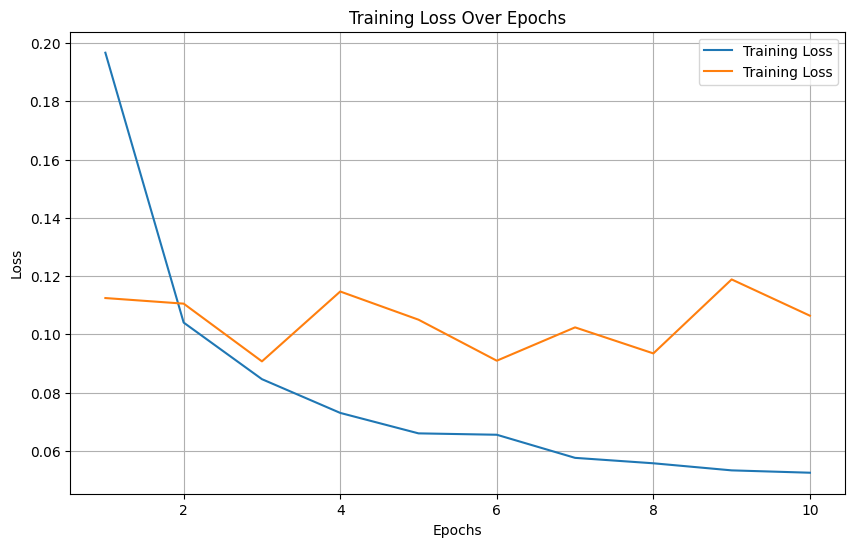

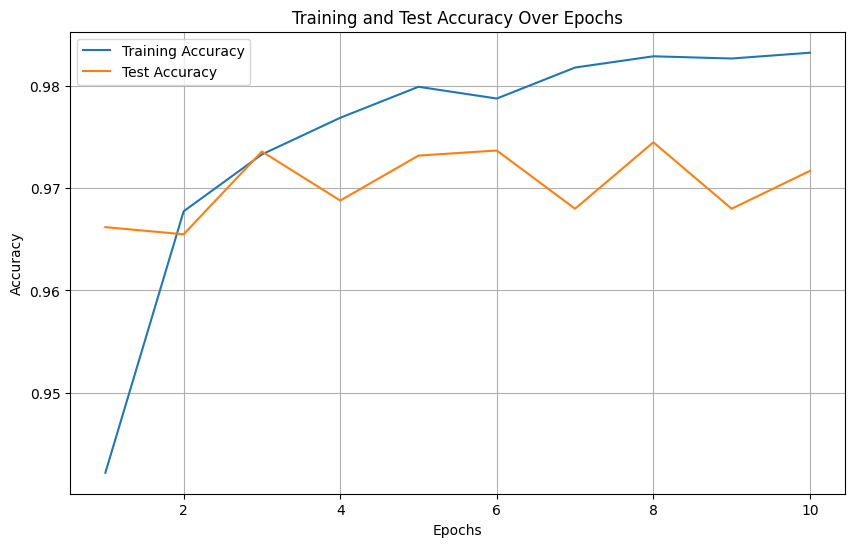

Final Test Accuracy: 0.9717


In [ ]:
# Load MNIST data
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Prepare data
batch_size = 64
train_mnist_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_mnist_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize DBN with layer sizes: input layer (784), two hidden layers (256, 128)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dbn = DBN(layer_sizes=[784, 256, 128], learning_rate=0.01, batch_size=batch_size)

# Pretrain DBN with unsupervised learning
dbn.pretrain(train_mnist_loader, epochs=10, device=device)

# Fine-tune DBN with supervised learning and get accuracy on the test set
accuracy = dbn.fine_tune(train_mnist_loader, test_mnist_loader, epochs=10, device=device)
print(f"Final Test Accuracy: {accuracy:.4f}")

### GTZAN Music dataset

Use the DBN model to solve music classification task

In [ ]:
# Initialize DBN with layer sizes: input layer (784), two hidden layers (256, 128)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dbn = DBN(layer_sizes=[513, 50, 49, 48], learning_rate=0.01, batch_size=BATCH_SIZE)

# Pretrain DBN with unsupervised learning
dbn.pretrain(train_loader, epochs=5, device=device)

# Fine-tune DBN with supervised learning and get accuracy on the test set
accuracy = dbn.fine_tune(train_loader, val_loader, epochs=120, device=device)
print(f"Final Test Accuracy: {accuracy:.4f}")

Pretraining RBM layer 1/3
Epoch 1/5


Training: 386048 samples [00:04, 84940.42 samples/s]                      


Epoch 2/5


Training: 386048 samples [00:04, 86493.26 samples/s]                      


Epoch 3/5


Training: 386048 samples [00:04, 86104.39 samples/s]                      


Epoch 4/5


Training: 386048 samples [00:04, 85395.92 samples/s]                      


Epoch 5/5


Training: 386048 samples [00:04, 83033.16 samples/s]                      


Pretraining RBM layer 2/3
Epoch 1/5


Training: 386048 samples [00:04, 85321.47 samples/s]                      


Epoch 2/5


Training: 386048 samples [00:04, 86368.05 samples/s]                      


Epoch 3/5


Training: 386048 samples [00:04, 86815.17 samples/s]                      


Epoch 4/5


Training: 386048 samples [00:04, 86185.33 samples/s]                      


Epoch 5/5


Training: 386048 samples [00:04, 86286.42 samples/s]                      


Pretraining RBM layer 3/3
Epoch 1/5


Training: 386048 samples [00:04, 86594.87 samples/s]                      


Epoch 2/5


Training: 386048 samples [00:04, 87084.99 samples/s]                      


Epoch 3/5


Training: 386048 samples [00:04, 86643.64 samples/s]                      


Epoch 4/5


Training: 386048 samples [00:04, 86545.12 samples/s]                      


Epoch 5/5


Training: 386048 samples [00:04, 87234.21 samples/s]                      
Epoch 1/120: 100%|██████████| 6032/6032 [03:37<00:00, 27.73it/s, Loss=1.7493, Accuracy on the training set=0.3617]


Epoch [1/120], Loss: 1.7493, Accuracy on the training set: 0.3617
Test Accuracy: 0.3969


Epoch 2/120: 100%|██████████| 6032/6032 [03:38<00:00, 27.62it/s, Loss=1.5711, Accuracy on the training set=0.4357]


Epoch [2/120], Loss: 1.5711, Accuracy on the training set: 0.4357
Test Accuracy: 0.4586


Epoch 3/120: 100%|██████████| 6032/6032 [03:39<00:00, 27.43it/s, Loss=1.4726, Accuracy on the training set=0.4767]


Epoch [3/120], Loss: 1.4726, Accuracy on the training set: 0.4767
Test Accuracy: 0.4899


Epoch 4/120: 100%|██████████| 6032/6032 [03:36<00:00, 27.82it/s, Loss=1.4018, Accuracy on the training set=0.5037]


Epoch [4/120], Loss: 1.4018, Accuracy on the training set: 0.5037
Test Accuracy: 0.5004


Epoch 5/120: 100%|██████████| 6032/6032 [03:36<00:00, 27.84it/s, Loss=1.3557, Accuracy on the training set=0.5215]


Epoch [5/120], Loss: 1.3557, Accuracy on the training set: 0.5215
Test Accuracy: 0.5246


Epoch 6/120: 100%|██████████| 6032/6032 [03:39<00:00, 27.44it/s, Loss=1.3177, Accuracy on the training set=0.5363]


Epoch [6/120], Loss: 1.3177, Accuracy on the training set: 0.5363
Test Accuracy: 0.5417


Epoch 7/120: 100%|██████████| 6032/6032 [03:41<00:00, 27.24it/s, Loss=1.2862, Accuracy on the training set=0.5471]


Epoch [7/120], Loss: 1.2862, Accuracy on the training set: 0.5471
Test Accuracy: 0.5444


Epoch 8/120: 100%|██████████| 6032/6032 [03:36<00:00, 27.87it/s, Loss=1.2604, Accuracy on the training set=0.5579]


Epoch [8/120], Loss: 1.2604, Accuracy on the training set: 0.5579
Test Accuracy: 0.5558


Epoch 9/120: 100%|██████████| 6032/6032 [03:35<00:00, 28.00it/s, Loss=1.2377, Accuracy on the training set=0.5660]


Epoch [9/120], Loss: 1.2377, Accuracy on the training set: 0.5660
Test Accuracy: 0.5572


Epoch 10/120: 100%|██████████| 6032/6032 [03:34<00:00, 28.06it/s, Loss=1.2173, Accuracy on the training set=0.5738]


Epoch [10/120], Loss: 1.2173, Accuracy on the training set: 0.5738
Test Accuracy: 0.5667


Epoch 11/120: 100%|██████████| 6032/6032 [03:35<00:00, 28.00it/s, Loss=1.2022, Accuracy on the training set=0.5791]


Epoch [11/120], Loss: 1.2022, Accuracy on the training set: 0.5791
Test Accuracy: 0.5762


Epoch 12/120: 100%|██████████| 6032/6032 [03:34<00:00, 28.09it/s, Loss=1.1872, Accuracy on the training set=0.5846]


Epoch [12/120], Loss: 1.1872, Accuracy on the training set: 0.5846
Test Accuracy: 0.5761


Epoch 13/120: 100%|██████████| 6032/6032 [03:35<00:00, 28.04it/s, Loss=1.1764, Accuracy on the training set=0.5889]


Epoch [13/120], Loss: 1.1764, Accuracy on the training set: 0.5889
Test Accuracy: 0.5779


Epoch 14/120: 100%|██████████| 6032/6032 [03:35<00:00, 27.99it/s, Loss=1.1664, Accuracy on the training set=0.5927]


Epoch [14/120], Loss: 1.1664, Accuracy on the training set: 0.5927
Test Accuracy: 0.5866


Epoch 15/120: 100%|██████████| 6032/6032 [03:35<00:00, 27.96it/s, Loss=1.1587, Accuracy on the training set=0.5950]


Epoch [15/120], Loss: 1.1587, Accuracy on the training set: 0.5950
Test Accuracy: 0.5834


Epoch 16/120: 100%|██████████| 6032/6032 [03:35<00:00, 27.97it/s, Loss=1.1495, Accuracy on the training set=0.5979]


Epoch [16/120], Loss: 1.1495, Accuracy on the training set: 0.5979
Test Accuracy: 0.5905


Epoch 17/120: 100%|██████████| 6032/6032 [03:35<00:00, 28.05it/s, Loss=1.1421, Accuracy on the training set=0.6005]


Epoch [17/120], Loss: 1.1421, Accuracy on the training set: 0.6005
Test Accuracy: 0.5911


Epoch 18/120: 100%|██████████| 6032/6032 [03:35<00:00, 28.00it/s, Loss=1.1359, Accuracy on the training set=0.6029]


Epoch [18/120], Loss: 1.1359, Accuracy on the training set: 0.6029
Test Accuracy: 0.5962


Epoch 19/120:   5%|▌         | 309/6032 [00:10<03:23, 28.12it/s, Loss=0.0572, Accuracy on the training set=0.6087]


KeyboardInterrupt: 

## Classification using svm from the output features of the RBMs

Train only the RBMs part from the DBM to use its final features to classify from these features

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dbn = DBN(layer_sizes=[513, 50, 49, 48], learning_rate=0.01, batch_size=BATCH_SIZE)
dbn.pretrain(train_loader, epochs=15, device=device)

Pretraining RBM layer 1/3
Epoch 1/15


Training: 386048 samples [00:04, 89683.09 samples/s]                      


Epoch 2/15


Training: 386048 samples [00:04, 84484.92 samples/s]                      


Epoch 3/15


Training: 386048 samples [00:04, 82804.81 samples/s]                      


Epoch 4/15


Training: 386048 samples [00:04, 91936.82 samples/s]                      


Epoch 5/15


Training: 386048 samples [00:04, 77450.43 samples/s]                      


Epoch 6/15


Training: 386048 samples [00:04, 90629.74 samples/s]                      


Epoch 7/15


Training: 386048 samples [00:04, 91211.28 samples/s]                      


Epoch 8/15


Training: 386048 samples [00:05, 76710.13 samples/s]                      


Epoch 9/15


Training: 386048 samples [00:04, 91395.87 samples/s]                      


Epoch 10/15


Training: 386048 samples [00:04, 92198.07 samples/s]                      


Epoch 11/15


Training: 386048 samples [00:05, 75561.96 samples/s]                      


Epoch 12/15


Training: 386048 samples [00:04, 92049.26 samples/s]                      


Epoch 13/15


Training: 386048 samples [00:04, 89346.13 samples/s]                      


Epoch 14/15


Training: 386048 samples [00:04, 78160.73 samples/s]                      


Epoch 15/15


Training: 386048 samples [00:04, 91021.61 samples/s]                      


Pretraining RBM layer 2/3
Epoch 1/15


Training: 386048 samples [00:04, 83585.44 samples/s]                      


Epoch 2/15


Training: 386048 samples [00:04, 83822.96 samples/s]                      


Epoch 3/15


Training: 386048 samples [00:04, 89338.63 samples/s]                      


Epoch 4/15


Training: 386048 samples [00:05, 75388.70 samples/s]                      


Epoch 5/15


Training: 386048 samples [00:04, 90435.77 samples/s]                      


Epoch 6/15


Training: 386048 samples [00:04, 89093.79 samples/s]                      


Epoch 7/15


Training: 386048 samples [00:05, 75680.80 samples/s]                      


Epoch 8/15


Training: 386048 samples [00:04, 91119.21 samples/s]                      


Epoch 9/15


Training: 386048 samples [00:04, 91146.94 samples/s]                      


Epoch 10/15


Training: 386048 samples [00:05, 75719.35 samples/s]                      


Epoch 11/15


Training: 386048 samples [00:04, 91360.73 samples/s]                      


Epoch 12/15


Training: 386048 samples [00:04, 85489.06 samples/s]                      


Epoch 13/15


Training: 386048 samples [00:04, 79584.15 samples/s]                      


Epoch 14/15


Training: 386048 samples [00:04, 90843.70 samples/s]                      


Epoch 15/15


Training: 386048 samples [00:04, 78322.38 samples/s]                      


Pretraining RBM layer 3/3
Epoch 1/15


Training: 386048 samples [00:04, 86663.87 samples/s]                      


Epoch 2/15


Training: 386048 samples [00:04, 90310.01 samples/s]                      


Epoch 3/15


Training: 386048 samples [00:05, 75340.75 samples/s]                      


Epoch 4/15


Training: 386048 samples [00:04, 90863.92 samples/s]                      


Epoch 5/15


Training: 386048 samples [00:04, 90232.49 samples/s]                      


Epoch 6/15


Training: 386048 samples [00:05, 64470.72 samples/s]                      


Epoch 7/15


Training: 386048 samples [00:04, 89644.34 samples/s]                      


Epoch 8/15


Training: 386048 samples [00:04, 88229.11 samples/s]                      


Epoch 9/15


Training: 386048 samples [00:04, 78039.11 samples/s]                      


Epoch 10/15


Training: 386048 samples [00:04, 91415.69 samples/s]                      


Epoch 11/15


Training: 386048 samples [00:04, 80948.55 samples/s]                      


Epoch 12/15


Training: 386048 samples [00:04, 84885.65 samples/s]                      


Epoch 13/15


Training: 386048 samples [00:04, 90492.10 samples/s]                      


Epoch 14/15


Training: 386048 samples [00:05, 76282.11 samples/s]                      


Epoch 15/15


Training: 386048 samples [00:04, 91428.71 samples/s]                      


Extract the features from the trained unsupervised RBMs

In [27]:
Z_train = torch.zeros((train_size, 48))
labels_train = torch.zeros((train_size))
for i, data in enumerate(train_loader):
  z = dbn.pretrain_forward(data[0].to(device))
  Z_train[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = z
  labels_train[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = data[1]

Define a svm to classify the samples from their features and train it  

In [28]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter = 1000)
clf.fit(Z_train.detach().numpy(), labels_train.detach().numpy())

LogisticRegression(max_iter=1000)

In [29]:
Z_test = torch.zeros((test_size, 48))
labels_test = torch.zeros((test_size))
for i, data in enumerate(test_loader):
  z = dbn.pretrain_forward(data[0].to(device))
  Z_test[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = z
  labels_test[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = data[1]

Predict classes from samples given their features obtained from DBN

In [30]:
labels_predicted_test = clf.predict(Z_test.detach().numpy())

Accuracy on the test set

In [31]:
print(accuracy_score(labels_test.detach().numpy(), labels_predicted_test))

0.09924304832367067
